In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.metrics import roc_auc_score
from lightgbm.sklearn import LGBMClassifier

## you'll have to pip install LGBM
# !pip install lightgbm

In [3]:
data_train = pd.read_csv("cleaned_2013_14", low_memory = False);
data_test = pd.read_csv("cleaned_2015", low_memory = False);

In [4]:
data_test = data_test.dropna()
data_test.columns == data_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [5]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

cols_to_drop_training = ['loan_status', 'paid', 'amnt', 'total_pymnt', 'term_adj', 'zip_code']
x_train_initial, y_train_initial = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)

In [6]:
sm = SMOTE(random_state=1, ratio = 1.0)
x_train, y_train = sm.fit_sample(x_train_initial, y_train_initial)

In [7]:
x_train.shape, x_test.shape

((578050, 44), (346843, 44))

In [8]:
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['bagging_fraction'] = 0.7
params['max_depth'] = 10
params['n_jobs'] = 5

In [11]:
# Use Pipeline instead of make_pipeline
pipe = Pipeline([('POLY', PolynomialFeatures(degree=2, include_bias=False)),
            ('LGBM',LGBMClassifier(learning_rate=0.01, boosting_type='gbdt',objective='binary',
                                  metric='binary_logloss',bagging_fraction=0.7, max_depth=10, n_jobs=5))])

lgbm = pipe.fit(x_train, y_train)

In [12]:
## Predict
train_predictions = lgbm.predict(x_train)
test_predictions = lgbm.predict(x_test)

## Accuracy Score
train_score = lgbm.score(x_train, y_train)
test_score = lgbm.score(x_test, y_test)

print("train accuracy: ", train_score)
print("test accuracy: ", test_score)

## AUC
train_predictions_class = np.where(train_predictions > 0.5, 1, 0)
test_predictions_class = np.where(test_predictions > 0.5, 1, 0)

print('Train ROC AUC: ', roc_auc_score(train_predictions_class, y_train))
print('Test  ROC AUC: ', roc_auc_score(test_predictions_class, y_test))

train accuracy:  0.7669336562581092
test accuracy:  0.6897184028508576
Train ROC AUC:  0.7679039589656171
Test  ROC AUC:  0.598861306294689


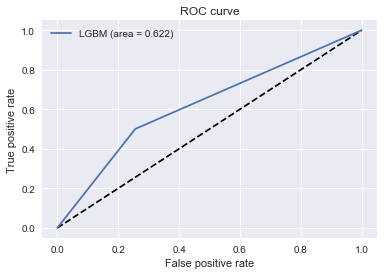

In [13]:
from sklearn.metrics import roc_curve
y_pred = lgbm.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

from sklearn.metrics import auc
auc_lgbm = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LGBM (area = {:.3f})'.format(auc_lgbm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [15]:
# Dump the trained Adaboost model with Pickle
# Open the file to save as pkl file
lgbm_pkl = open('LGBM1.pkl', 'wb')
pickle.dump(lgbm, lgbm_pkl)
# Close the pickle instances
lgbm_pkl.close()